# Brain age regression with fastai

( Modified from https://analyticsindiamag.com/a-hands-on-guide-to-regression-with-fast-ai )

In [125]:
# Import all libraries needed for the exploration

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # this is how we usually import pandas
import numpy as np # this is how we usually import numpy
import sys # only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
from fastai.tabular import *

# Enable inline plotting
%matplotlib inline

In [126]:
# Supress some warnings:
import warnings
warnings.filterwarnings('ignore')

In [127]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)

Python version 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Pandas version 0.25.3
Numpy version 1.17.4
Matplotlib version 3.1.2
Seaborn version 0.9.0


## Training data

In [128]:
train_data = pd.read_csv('../data/train.csv')

## Test data

In [129]:
test_data = pd.read_csv('../data/test.csv')

### Explore the data

In [130]:
# Check the number of data points in the data set
print('No observations:', len(train_data))
# Check the number of features in the data set
print('No variables:', len(train_data.columns))
# Check the data types
print(train_data.dtypes.unique())

No observations: 1085
No variables: 152
[dtype('int64') dtype('O') dtype('float64')]


In [131]:
train_data.shape

(1085, 152)

In [132]:
train_data.columns

Index(['SubjectID', 'Source', 'ID', 'Sex', 'Height', 'Weight', 'FieldStrength',
       'Handedness', 'Measure:volume', 'Left-Lateral-Ventricle',
       ...
       'rh_superiortemporal_thickness', 'rh_supramarginal_thickness',
       'rh_frontalpole_thickness', 'rh_temporalpole_thickness',
       'rh_transversetemporal_thickness', 'rh_insula_thickness',
       'rh_MeanThickness_thickness', 'BrainSegVolNotVent', 'eTIV_y', 'Age'],
      dtype='object', length=152)

In [133]:
for i, col in enumerate(train_data.columns, start=0):
    print(i, col)

0 SubjectID
1 Source
2 ID
3 Sex
4 Height
5 Weight
6 FieldStrength
7 Handedness
8 Measure:volume
9 Left-Lateral-Ventricle
10 Left-Inf-Lat-Vent
11 Left-Cerebellum-White-Matter
12 Left-Cerebellum-Cortex
13 Left-Thalamus-Proper
14 Left-Caudate
15 Left-Putamen
16 Left-Pallidum
17 3rd-Ventricle
18 4th-Ventricle
19 Brain-Stem
20 Left-Hippocampus
21 Left-Amygdala
22 CSF
23 Left-Accumbens-area
24 Left-VentralDC
25 Left-vessel
26 Left-choroid-plexus
27 Right-Lateral-Ventricle
28 Right-Inf-Lat-Vent
29 Right-Cerebellum-White-Matter
30 Right-Cerebellum-Cortex
31 Right-Thalamus-Proper
32 Right-Caudate
33 Right-Putamen
34 Right-Pallidum
35 Right-Hippocampus
36 Right-Amygdala
37 Right-Accumbens-area
38 Right-VentralDC
39 Right-vessel
40 Right-choroid-plexus
41 5th-Ventricle
42 WM-hypointensities
43 Left-WM-hypointensities
44 Right-WM-hypointensities
45 non-WM-hypointensities
46 Left-non-WM-hypointensities
47 Right-non-WM-hypointensities
48 Optic-Chiasm
49 CC_Posterior
50 CC_Mid_Posterior
51 CC_Central

In [134]:
# We may have some categorical features, let's check them
train_data.select_dtypes(include=['O']).columns.tolist()

['Source',
 'ID',
 'Sex',
 'FieldStrength',
 'lh.aparc.thickness',
 'rh.aparc.thickness']

In [135]:
# Check any number of columns with NaN
print(train_data.isnull().any().sum(), ' / ', len(train_data.columns))
# Check number of data points with any NaN
print(train_data.isnull().any(axis=1).sum(), ' / ', len(train_data))

4  /  152
1085  /  1085


### Select features and targets

In [136]:
features = train_data.iloc[:,9:-1].columns.tolist()
target = train_data.iloc[:,-1].name

In [137]:
all_lh_features = [
 'CSF', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'EstimatedTotalIntraCranialVol',
 'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Left-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'lhCortexVol',
 'lhCerebralWhiteMatterVol',            
 'lhSurfaceHoles',  
 'lh.aparc.thickness',
 'lh_bankssts_thickness',
 'lh_caudalanteriorcingulate_thickness',
 'lh_caudalmiddlefrontal_thickness',
 'lh_cuneus_thickness',
 'lh_entorhinal_thickness',
 'lh_fusiform_thickness',
 'lh_inferiorparietal_thickness',
 'lh_inferiortemporal_thickness',
 'lh_isthmuscingulate_thickness',
 'lh_lateraloccipital_thickness',
 'lh_lateralorbitofrontal_thickness',
 'lh_lingual_thickness',
 'lh_medialorbitofrontal_thickness',
 'lh_middletemporal_thickness',
 'lh_parahippocampal_thickness',
 'lh_paracentral_thickness',
 'lh_parsopercularis_thickness',
 'lh_parsorbitalis_thickness',
 'lh_parstriangularis_thickness',
 'lh_pericalcarine_thickness',
 'lh_postcentral_thickness',
 'lh_posteriorcingulate_thickness',
 'lh_precentral_thickness',
 'lh_precuneus_thickness',
 'lh_rostralanteriorcingulate_thickness',
 'lh_rostralmiddlefrontal_thickness',
 'lh_superiorfrontal_thickness',
 'lh_superiorparietal_thickness',
 'lh_superiortemporal_thickness',
 'lh_supramarginal_thickness',
 'lh_frontalpole_thickness',
 'lh_temporalpole_thickness',
 'lh_transversetemporal_thickness',
 'lh_insula_thickness',
 'lh_MeanThickness_thickness'
 ]

In [138]:
# Make rh_ and Right- names (base on LHs)

# List comprehensions
rh_names = [w.replace('lh_', 'rh_') for w in all_lh_features]
Right_names = [w.replace('Left-', 'Right-') for w in rh_names]
most_rh_names = [w.replace('lhC', 'rhC') for w in Right_names]
all_rh_names = [w.replace('lhS', 'rhS') for w in most_rh_names]
all_rh_features = [w.replace('lh.', 'rh.') for w in all_rh_names]
all_rh_features

['CSF',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'EstimatedTotalIntraCranialVol',
 'Right-Lateral-Ventricle',
 'Right-Inf-Lat-Vent',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus',
 'Right-WM-hypointensities',
 'Right-non-WM-hypointensities',
 'rhCortexVol',
 'rhCerebralWhiteMatterVol',
 'rhSurfaceHoles',
 'rh.aparc.thickness',
 'rh_bankssts_thickness',
 'rh_caudalanteriorcingulate_thickness',
 'rh_caudalmiddlefrontal_thickness',
 'rh_cuneus_thickness',
 'rh_entorhinal_thickness',
 'rh_fusiform_thickness',
 'rh_inferiorparietal_thickness',
 'rh_inferiortemporal_thickness',
 'rh_isthmuscingulate_thickness',
 'rh_lateraloccipital_thickness',
 'rh_lateralorbitofrontal_thickness',
 'rh_lingual_thickness',
 'rh_medialorbito

In [139]:
train_data_lh = train_data[all_lh_features]
train_data_rh = train_data[all_rh_features]

In [140]:
train_data_lh.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CSF,1085.0,1032.72,275.51,550.90,849.50,989.90,1154.00,3135.60
CC_Posterior,1085.0,998.76,165.01,259.40,890.20,996.00,1085.90,1824.10
CC_Mid_Posterior,1085.0,564.41,133.13,115.50,479.50,548.60,632.40,1447.20
CC_Central,1085.0,660.53,182.18,255.70,511.10,656.20,794.80,1289.50
CC_Mid_Anterior,1085.0,646.39,178.89,247.40,504.60,634.80,769.00,1294.70
...,...,...,...,...,...,...,...,...
lh_frontalpole_thickness,1085.0,2.84,0.29,1.58,2.64,2.85,3.02,3.68
lh_temporalpole_thickness,1085.0,3.68,0.29,2.29,3.51,3.70,3.88,4.46
lh_transversetemporal_thickness,1085.0,2.30,0.23,1.26,2.16,2.31,2.46,3.04
lh_insula_thickness,1085.0,2.97,0.19,1.50,2.87,2.98,3.10,3.55


In [141]:
train_data_rh.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CSF,1085.0,1032.72,275.51,550.90,849.50,989.90,1154.00,3135.60
CC_Posterior,1085.0,998.76,165.01,259.40,890.20,996.00,1085.90,1824.10
CC_Mid_Posterior,1085.0,564.41,133.13,115.50,479.50,548.60,632.40,1447.20
CC_Central,1085.0,660.53,182.18,255.70,511.10,656.20,794.80,1289.50
CC_Mid_Anterior,1085.0,646.39,178.89,247.40,504.60,634.80,769.00,1294.70
...,...,...,...,...,...,...,...,...
rh_frontalpole_thickness,1085.0,2.81,0.28,1.98,2.63,2.80,3.01,3.74
rh_temporalpole_thickness,1085.0,3.76,0.30,2.23,3.57,3.78,3.96,4.57
rh_transversetemporal_thickness,1085.0,2.35,0.24,1.31,2.22,2.37,2.52,3.05
rh_insula_thickness,1085.0,2.99,0.20,1.49,2.87,3.00,3.12,3.59


In [142]:
dropcolumns = [
    'EstimatedTotalIntraCranialVol',
    'CSF', 
    'CC_Posterior', 
    'CC_Mid_Posterior', 
    'CC_Central', 
    'CC_Mid_Anterior', 
    'CC_Anterior'   
]

df_lh = train_data_lh.drop(dropcolumns, axis=1)
df_rh = train_data_rh.drop(dropcolumns, axis=1)
df_lh

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_MeanThickness_thickness
0,5968.4,212.0,12717.4,54979.7,8170.7,3773.4,5204.9,1956.4,4150.9,1515.2,...,2.560,2.924,2.379,2.953,2.642,3.043,3.662,2.460,3.062,2.63478
1,12256.1,241.9,15603.7,50793.1,8513.6,4153.9,5317.9,2330.4,3971.8,1692.1,...,2.530,2.981,2.333,2.817,2.715,2.763,3.699,2.395,3.242,2.60656
2,4764.0,202.1,13745.1,44080.0,7312.0,3320.8,4137.5,1797.2,3465.7,1377.4,...,2.551,2.882,2.286,2.790,2.710,2.676,4.050,2.225,2.902,2.57094
3,10770.0,532.2,13814.3,50342.0,7367.5,2726.2,4771.3,2122.2,4046.3,1476.0,...,2.418,2.516,2.180,2.780,2.662,2.880,3.712,2.179,2.566,2.45492
4,6773.7,517.0,15662.8,54779.1,7156.6,3357.3,4940.3,2010.9,4109.7,1435.1,...,2.302,2.505,2.062,2.579,2.453,2.736,3.646,1.956,2.889,2.36957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,3794.7,31.7,19280.4,58613.7,8924.1,3090.4,5180.6,2285.0,4595.9,1527.1,...,2.408,2.603,2.162,2.468,2.301,2.857,3.066,1.928,2.742,2.38182
1081,17935.0,473.7,16101.9,48996.3,6542.0,3430.0,3995.2,2043.6,3513.4,1403.0,...,2.164,2.458,2.039,2.501,2.425,2.373,3.441,2.077,2.423,2.28107
1082,3116.1,98.7,14541.8,58064.3,6351.6,2885.1,3963.1,1695.5,3680.0,1393.1,...,2.324,2.646,2.066,2.761,2.494,2.788,3.511,2.294,2.928,2.45424
1083,9992.8,412.2,15710.0,54893.8,6730.6,3002.5,3941.9,1888.4,3547.3,1340.1,...,2.154,2.401,1.956,2.563,2.238,2.741,3.286,1.779,2.458,2.20697


### Path / default location for saving/loading models

In [143]:
path = ''

### The dependent variable/target

In [144]:
dep_var = 'Age'

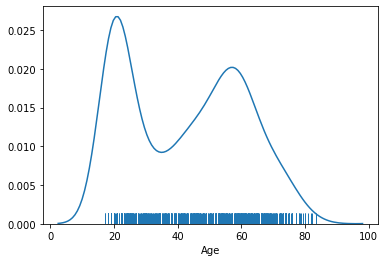

In [145]:
y = train_data[dep_var]
sns.distplot(y, hist=False, rug=True)

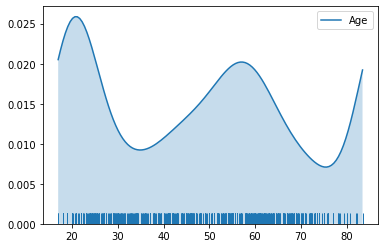

In [146]:
sns.kdeplot(y, shade=True, cut=0)
sns.rugplot(y)
plt.show()

### The list of categorical features in the dataset

In [147]:
cat_names = ['Sex']

### The list of continuous features in the dataset

In [148]:
cont_names = [
    'Left-Lateral-Ventricle', 'Right-Lateral-Ventricle',
    'lhCortexVol', 'rhCortexVol',
    'lhCerebralWhiteMatterVol', 'rhCerebralWhiteMatterVol'
]

### List of processes/transforms to be applied to the dataset

In [149]:
procs = [FillMissing, Categorify, Normalize]

### Start index for creating a validation set from train_data
Setting the index for the Validation set. The start index and End index are set in such a way that it takes the last 20% data from the training set for validation.

In [150]:
start_indx = len(train_data) - int(len(train_data) * 0.2)

### End index for creating a validation set from train_data

In [151]:
end_indx = len(train_data)

### TabularList for Validation

In [152]:
val = (TabularList.from_df(train_data.iloc[start_indx:end_indx].copy(), path=path, cat_names=cat_names, cont_names=cont_names))

In [153]:
test = (TabularList.from_df(test_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs))

### TabularList for training

In [154]:
data = (TabularList.from_df(train_data, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(start_indx,end_indx)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

### Display the data batch

In [155]:
data.show_batch(rows = 10)

Sex,Left-Lateral-Ventricle,Right-Lateral-Ventricle,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,target
M,0.1586,0.1827,1.5449,1.5041,0.3865,0.3417,20.0
M,-0.3624,-0.1659,0.5399,0.5257,-0.2752,-0.2988,24.0
M,0.3316,-0.0420,-0.5235,-0.6149,-0.2581,-0.3131,49.0
F,-0.7868,-0.9416,-0.1798,-0.2516,-1.2810,-1.3020,20.0
M,-0.7258,-0.5828,-0.2149,-0.2891,1.6202,1.5945,42.0
F,1.8942,1.5499,-0.8323,-0.7877,-0.4156,-0.5882,64.64613
M,-0.9075,-0.9462,0.7046,0.5414,1.8873,1.9772,29.256674
F,-0.9109,-0.3374,1.2433,1.1976,1.2551,1.1167,26.579056
F,0.2784,0.3577,0.0299,0.0551,-0.1341,-0.1299,61.0
M,1.3903,2.3902,0.1664,0.1421,-0.6600,-0.6598,52.0


## Initialising Neural Network
We will initialize a neural network with 4 layers and the number of nodes in each layer as 300,200, 100 and 50 respectively. 

The network will use two primary metrics for evaluation:

 - Root Mean Squared Error(RMSE)
 - R-Squared

In [156]:
learn = tabular_learner(data, layers=[300,200, 100, 50], metrics= [rmse,r2_score])

### Show the complete summary of the model

In [157]:
learn.summary

<bound method model_summary of Learner(data=TabularDataBunch;

Train: LabelList (868 items)
x: TabularList
Sex F; Left-Lateral-Ventricle -0.4912; Right-Lateral-Ventricle -0.5929; lhCortexVol 0.3690; rhCortexVol -0.3121; lhCerebralWhiteMatterVol -0.3962; rhCerebralWhiteMatterVol -0.8094; ,Sex F; Left-Lateral-Ventricle 0.6353; Right-Lateral-Ventricle 0.1380; lhCortexVol 0.8157; rhCortexVol 0.8589; lhCerebralWhiteMatterVol 0.1290; rhCerebralWhiteMatterVol 0.2122; ,Sex F; Left-Lateral-Ventricle -0.7070; Right-Lateral-Ventricle -0.7804; lhCortexVol -1.0062; rhCortexVol -1.0757; lhCerebralWhiteMatterVol -0.7122; rhCerebralWhiteMatterVol -0.6674; ,Sex M; Left-Lateral-Ventricle 0.3691; Right-Lateral-Ventricle -0.0885; lhCortexVol -0.3746; rhCortexVol -0.4177; lhCerebralWhiteMatterVol 0.5464; rhCerebralWhiteMatterVol 0.4964; ,Sex M; Left-Lateral-Ventricle -0.3469; Right-Lateral-Ventricle 0.3438; lhCortexVol -0.5295; rhCortexVol -0.5584; lhCerebralWhiteMatterVol 0.7260; rhCerebralWhiteMatterVol 

## Training the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


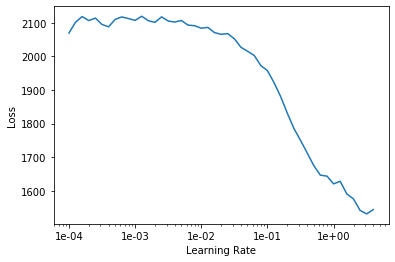

In [158]:
# Exploring the learning rates
learn.lr_find(start_lr = 1e-05,end_lr = 1e+05, num_it = 100)
learn.recorder.plot()

Learning rate is a hyper-parameter that controls how much the weights of the network is being adjusted with respect to the loss gradient. The lr_find method helps explore the learning rate in a specified range. The graph shows the deviation in loss with respect to the learning rate.

### Fitting data and training the network

In [159]:
# Train the network for 25 epochs
learn.fit_one_cycle(50)

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,2114.888672,2159.055664,46.414188,-4.990332,00:00
1,2100.518066,2131.495850,46.122803,-4.915802,00:00
2,2083.688721,2081.635986,45.587521,-4.779751,00:00
3,2073.434570,2045.932495,45.198925,-4.681972,00:00
4,2061.554199,2010.776733,44.814220,-4.585757,00:00
5,2043.322388,1972.217651,44.383739,-4.478882,00:00
6,2026.866333,1937.575562,43.995441,-4.383606,00:00
7,2005.482788,1869.462524,43.220695,-4.196807,00:00
8,1971.592896,1813.279053,42.574268,-4.047777,00:00
9,1925.183350,1700.306763,41.226742,-3.730788,00:00


### Evaluating the model
The `show_results` method will display the data bunches along with predicted values. 

In [160]:
# Display predictions on the training data
learn.show_results(ds_type=DatasetType.Train,rows = 5)

Sex,Left-Lateral-Ventricle,Right-Lateral-Ventricle,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,target,prediction
F,-1.1082,-1.0160,0.3243,0.4430,1.3082,1.4604,40.03559,[31.431976]
M,-0.0156,-0.0937,0.2618,0.2221,0.1881,0.3759,34.056126,[50.283726]
M,-0.1992,-0.2880,1.9793,1.9316,0.8213,0.7867,20.0,[22.467136]
M,1.0772,2.2009,0.4233,0.4910,1.0783,1.1648,51.0,[47.73993]
M,-0.6211,-0.6419,1.2870,1.3113,-0.3854,-0.3507,21.0,[20.689587]


In [161]:
# Display predictions on the validation data
learn.show_results(ds_type=DatasetType.Valid)

Sex,Left-Lateral-Ventricle,Right-Lateral-Ventricle,lhCortexVol,rhCortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,target,prediction
F,-0.0442,0.0265,-0.3300,-0.3715,-0.0418,-0.1020,60.0,[52.960884]
M,-0.5186,-0.3297,0.7855,0.9216,-0.7080,-0.6231,21.0,[20.820286]
M,-0.1648,-0.4684,1.9247,1.8902,0.0475,0.0974,23.0,[21.511791]
M,-0.2763,-0.4320,-0.2885,-0.1839,0.2009,0.2833,56.67625,[42.715233]
F,-0.8002,-0.9145,-1.2407,-1.2732,-1.0103,-1.2383,39.397675,[37.46489]


### Fetching the Metrics 

In [162]:
# Getting the training and validation errors
tr = learn.validate(learn.data.train_dl)
va = learn.validate(learn.data.valid_dl)
print("The metrics used in evaluating the network:", str(learn.metrics))
print("\nThe calculated RMSE & R-Squared for the training set :", tr[1:])
print("\nThe calculated RMSE & R-Squared for the validation set :", va[1:])

The metrics used in evaluating the network: [<function root_mean_squared_error at 0x7f31e6b77290>, <function r2_score at 0x7f31e6b77440>]

The calculated RMSE & R-Squared for the training set : [tensor(8.1050), tensor(0.7971)]

The calculated RMSE & R-Squared for the validation set : [tensor(9.7007), tensor(0.7299)]


#### SUMMARY

The Root Mean Squared Error is the standard deviation of the errors/residuals. It tells us the ‘Goodness Of Fit’ of a model. The lower the value of RMSE the better the model.

The R-Squared metric also called the coefficient of determination is used to understand the variation in the dependent variable(y) and the independent variable(X).The closer the value of R-Squared is to one, the better the model.

The above output suggests that:

The model/network was able to attain an RMSE of 1.4678 and an R-squared of 0.9726 while training and an RMSE of 3.1737 and an R-squared of 0.9107 while Validating on the validation set.

### Plotting the losses for training and validation

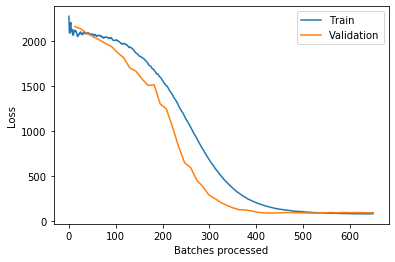

In [163]:
learn.recorder.plot_losses()

The above graph shows the change in loss during the course of training the network. At the beginning of the training, we can see a high loss value. As the networks learned from the data, the loss started to drop until it could no longer improve during the course of training. The validation shows a relatively consistent and low loss values. 

Note: The validation losses are only calculated once per epoch, whereas training losses are calculated after each batch

### Plotting the learning rate, momentum and metrics

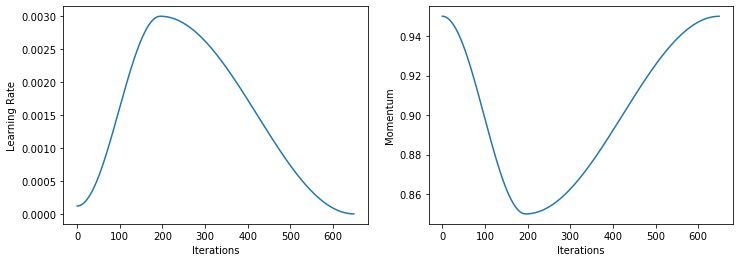

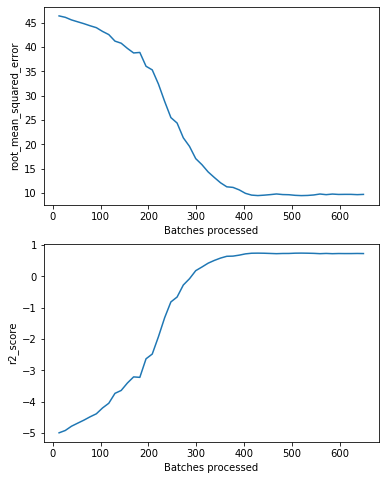

In [164]:
# Plotting momentum & learning rate
learn.recorder.plot_lr(show_moms=True)
# Plotting the metrics of evaluation
learn.recorder.plot_metrics()

### A simple analysis on the predictions of validation set

Plotting the average Age for a given Sex, -- actual vs predicted

No handles with labels found to put in legend.


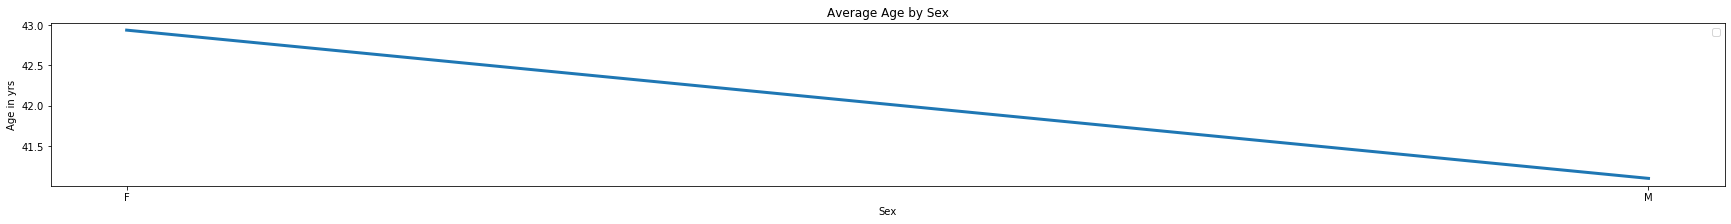

In [165]:
plt.figure(figsize=(30, 3))
# plt.plot(val.groupby(['Sex']).mean()['Age'], linewidth = 3, )
plt.plot(train_data.groupby(['Sex']).mean()['Age'], linewidth = 3, )
#plt.plot(val.groupby(['Sex']).mean()['Predicted'],linewidth = 5, ls  = '--')
plt.title('Average Age by Sex')
plt.xlabel('Sex')
plt.ylabel('Age in yrs')
plt.legend()
plt.show()

## Predicting Using The Network

In [166]:
# Predicting for a single observation
# Test set data for row 0
test_data.iloc[0]

SubjectID                                  117
Sex                                          F
Measure:volume                               0
Left-Lateral-Ventricle                  9018.3
Left-Inf-Lat-Vent                          293
                                      ...     
rh_transversetemporal_thickness          2.259
rh_insula_thickness                      2.923
rh_MeanThickness_thickness             2.43364
BrainSegVolNotVent                 1.07088e+06
eTIV_y                             1.44902e+06
Name: 0, Length: 145, dtype: object

In [167]:
# Predicting for the complete test set
test_predictions = learn.get_preds(ds_type=DatasetType.Test)[0]

# Converting the tensor output to a list of predicted values
test_predictions = [i[0] for i in test_predictions.tolist()]

# Converting the prediction to a dataframe
test_predictions = pd.DataFrame(test_predictions, columns = ['Age'])

# Writing the predictions to an csv file.
test_predictions.to_csv("Fast_ai_solution.csv", index = False)

### Discretization of Age variable
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [168]:
pd.qcut(train_data['Age'], 8).head(1)

0    (16.999, 20.0]
Name: Age, dtype: category
Categories (8, interval[float64]): [(16.999, 20.0] < (20.0, 21.0] < (21.0, 30.06] < (30.06, 44.0] < (44.0, 52.515] < (52.515, 58.0] < (58.0, 64.0] < (64.0, 83.458]]